MiniLM shape: (10000, 384)
DeTeCtive shape: (10000, 384)
Labels shape: (10000,)  | classes: [0 1]
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.222155
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.678650
[t-SNE] KL divergence after 2000 iterations: 2.761733


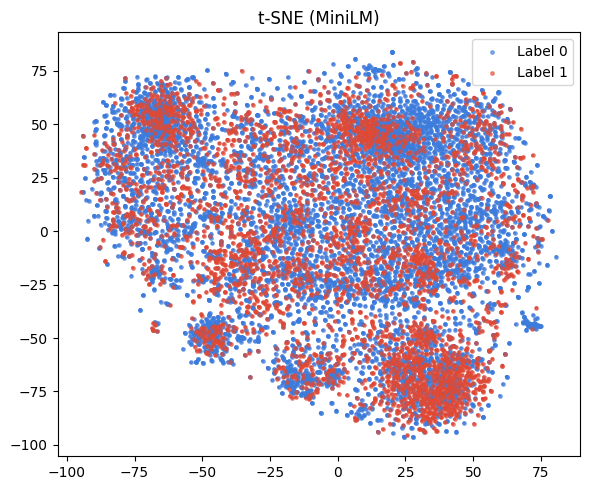

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.740s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.182350
[t-SNE] KL divergence after 2000 iterations: 1.981001


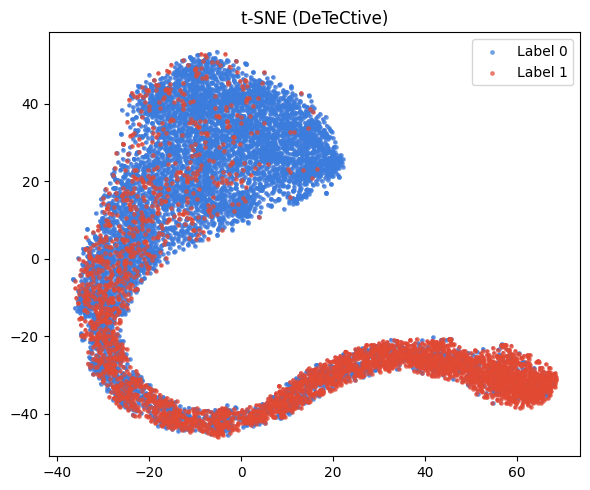

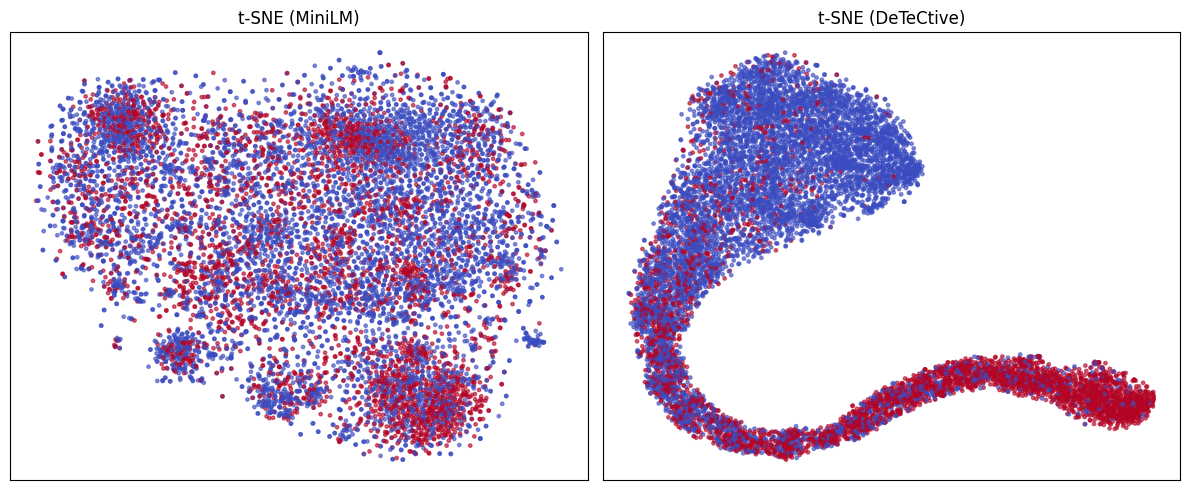

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ------------------- 配置 -------------------
MINILM_EMB = "data/text_embeddings.npy"        # MiniLM
DETECTIVE_EMB = "data/detective_emb_384.npy"   # DeTeCtive
DATA_FILE = "data/data.csv"                    # 含 label 列（0/1）

random_state = 42
perplexity = 50          # 10k样本可取 30/50/80 之一
learning_rate = 800      # ~ max(N/12, 200)
n_iter = 2000
use_pca = False           # 若要“纯 t-SNE”，置为 False
pca_dim = 50

# ------------------- 读取数据 -------------------
X_minilm = np.load(MINILM_EMB)
X_detective = np.load(DETECTIVE_EMB)
y = pd.read_csv(DATA_FILE)["label"].values

assert len(X_minilm) == len(y), "MiniLM 向量与标签数量不一致"
assert len(X_detective) == len(y), "DeTeCtive 向量与标签数量不一致"

print("MiniLM shape:", X_minilm.shape)
print("DeTeCtive shape:", X_detective.shape)
print("Labels shape:", y.shape, " | classes:", np.unique(y))

# ------------------- 可视化函数 -------------------
def run_tsne(X, y, title, savepath, use_pca=True):
    X_in = X
    if use_pca:
        pca = PCA(n_components=min(pca_dim, X.shape[1]), random_state=random_state)
        X_in = pca.fit_transform(X)
        print(f"{title}: PCA->{X_in.shape[1]}D, explained_var_sum={pca.explained_variance_ratio_.sum():.3f}")

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        metric="cosine",       # 文本/句向量推荐使用 cosine
        init="pca",            # 更稳定
        random_state=random_state,
        verbose=1
    )
    X_2d = tsne.fit_transform(X_in)

    plt.figure(figsize=(6,5))
    # 颜色映射：0/1 两类
    scatter = plt.scatter(
        X_2d[:,0], X_2d[:,1],
        c=y, s=6, alpha=0.6, cmap="coolwarm", linewidths=0
    )
    handles = []
    for cls, color in zip([0,1], ["#3B7DDD", "#E24A33"]):
        mask = (y == cls)
        h = plt.scatter(X_2d[mask,0], X_2d[mask,1], s=6, alpha=0.6, c=[color], label=f"Label {cls}")
        handles.append(h)
    plt.legend(loc="best", frameon=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savepath, dpi=200)
    plt.show()
    return X_2d

# ------------------- 分别绘制 -------------------
Z_minilm = run_tsne(X_minilm, y, "t-SNE (MiniLM)", "tsne_minilm.png", use_pca=use_pca)
Z_detective = run_tsne(X_detective, y, "t-SNE (DeTeCtive)", "tsne_detective.png", use_pca=use_pca)

# ------------------- 并排对比图 -------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(Z_minilm[:,0], Z_minilm[:,1], c=y, s=6, alpha=0.6, cmap="coolwarm")
plt.title("t-SNE (MiniLM)")
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
plt.scatter(Z_detective[:,0], Z_detective[:,1], c=y, s=6, alpha=0.6, cmap="coolwarm")
plt.title("t-SNE (DeTeCtive)")
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.savefig("tsne_side_by_side.png", dpi=200)
plt.show()


MiniLM: (10000, 384) DeTeCtive: (10000, 384) Labels: (array([0, 1]), array([6455, 3545]))
Running t-SNE for MiniLM...
Running t-SNE for DeTeCtive...


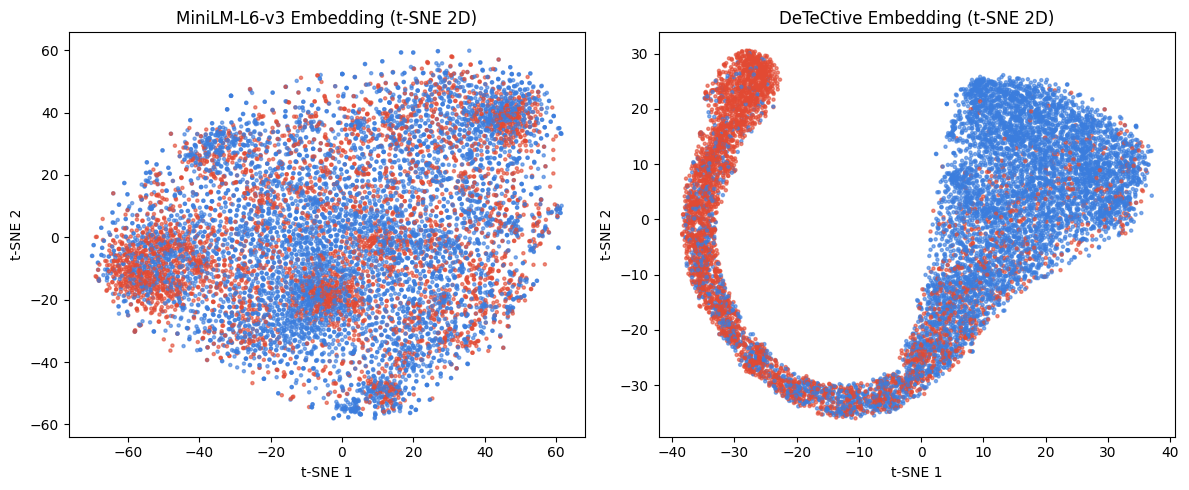

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

# =======================
# Load Data
# =======================
# MiniLM
X_minilm = np.load("data/text_embeddings.npy")
# DeTeCtive
X_detective = np.load("data/detective_emb_384.npy")
# labels
y = pd.read_csv("data/data.csv")["label"].values

print("MiniLM:", X_minilm.shape, "DeTeCtive:", X_detective.shape, "Labels:", np.unique(y, return_counts=True))

# =======================
# Normalize (L2 norm)
# =======================
X_minilm = normalize(X_minilm)
X_detective = normalize(X_detective)

# =======================
# t-SNE to 2D
# =======================
tsne = TSNE(n_components=2, perplexity=80, random_state=42)

print("Running t-SNE for MiniLM...")
X_minilm_2d = tsne.fit_transform(X_minilm)

print("Running t-SNE for DeTeCtive...")
X_detective_2d = tsne.fit_transform(X_detective)

# =======================
# Plot
# =======================
colors = np.array(["#3B7DDD", "#E24A33"])  # label 0 → 蓝，label 1 → 橙

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(
    X_minilm_2d[:, 0], X_minilm_2d[:, 1],
    c=colors[y],
    s=5, alpha=0.6
)
axes[0].set_title("MiniLM-L6-v3 Embedding (t-SNE 2D)")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

axes[1].scatter(
    X_detective_2d[:, 0], X_detective_2d[:, 1],
    c=colors[y],
    s=5, alpha=0.6
)
axes[1].set_title("DeTeCtive Embedding (t-SNE 2D)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

MiniLM PCA explained variance (2D): 0.0750
DeTeCtive PCA explained variance (2D): 0.9769


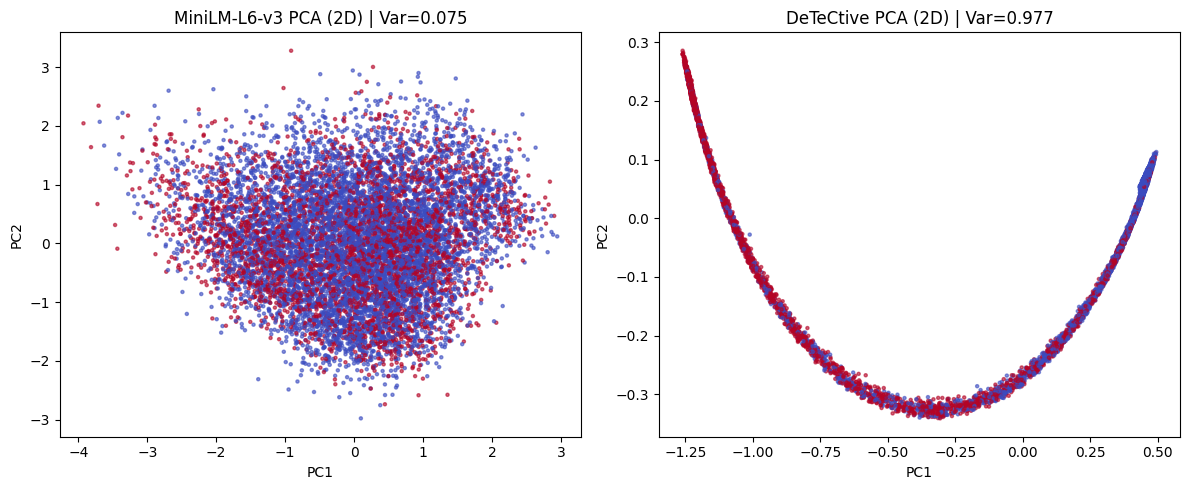

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd

# =======================
# 加载数据
# =======================
X_minilm = np.load("data/text_embeddings.npy")
X_detective = np.load("data/detective_emb_384.npy")
y = pd.read_csv("data/data.csv")["label"].values


pca_minilm = PCA(n_components=2, random_state=42)
X_minilm_pca = pca_minilm.fit_transform(X_minilm)
explained_minilm = pca_minilm.explained_variance_ratio_.sum()

pca_detective = PCA(n_components=2, random_state=42)
X_detective_pca = pca_detective.fit_transform(X_detective)
explained_detective = pca_detective.explained_variance_ratio_.sum()

print(f"MiniLM PCA explained variance (2D): {explained_minilm:.4f}")
print(f"DeTeCtive PCA explained variance (2D): {explained_detective:.4f}")

# =======================
# 可视化
# =======================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_minilm_pca[:, 0], X_minilm_pca[:, 1],
                c=y, cmap='coolwarm', s=5, alpha=0.6)
axes[0].set_title(f"MiniLM-L6-v3 PCA (2D) | Var={explained_minilm:.3f}")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

axes[1].scatter(X_detective_pca[:, 0], X_detective_pca[:, 1],
                c=y, cmap='coolwarm', s=5, alpha=0.6)
axes[1].set_title(f"DeTeCtive PCA (2D) | Var={explained_detective:.3f}")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


MiniLM PCA explained variance (2D): 0.0750
DeTeCtive PCA explained variance (2D): 0.0827


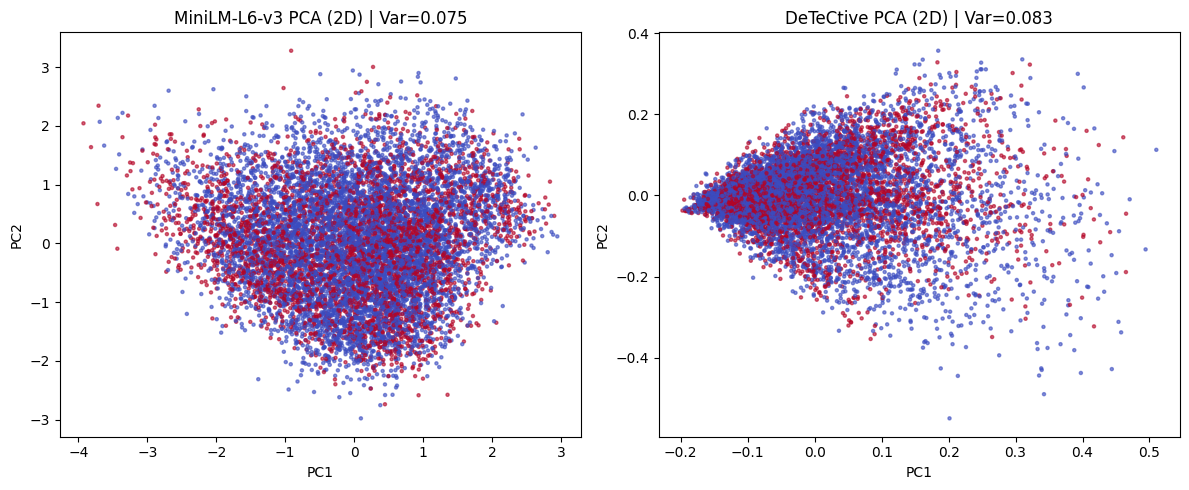

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd

# =======================
# 加载数据
# =======================
X_minilm = np.load("data/text_embeddings.npy")
X_detective = np.load("data/text_embeddings_tfidf.npy")
y = pd.read_csv("data/data.csv")["label"].values


pca_minilm = PCA(n_components=2, random_state=42)
X_minilm_pca = pca_minilm.fit_transform(X_minilm)
explained_minilm = pca_minilm.explained_variance_ratio_.sum()

pca_detective = PCA(n_components=2, random_state=42)
X_detective_pca = pca_detective.fit_transform(X_detective)
explained_detective = pca_detective.explained_variance_ratio_.sum()

print(f"MiniLM PCA explained variance (2D): {explained_minilm:.4f}")
print(f"DeTeCtive PCA explained variance (2D): {explained_detective:.4f}")

# =======================
# 可视化
# =======================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_minilm_pca[:, 0], X_minilm_pca[:, 1],
                c=y, cmap='coolwarm', s=5, alpha=0.6)
axes[0].set_title(f"MiniLM-L6-v3 PCA (2D) | Var={explained_minilm:.3f}")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

axes[1].scatter(X_detective_pca[:, 0], X_detective_pca[:, 1],
                c=y, cmap='coolwarm', s=5, alpha=0.6)
axes[1].set_title(f"DeTeCtive PCA (2D) | Var={explained_detective:.3f}")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()
